# Guided Project: Analyzing NYC High School Data
### *By: Naftali N Indongo*

# 1. Introduction

In other lessons, we have explored relationships between SAT scores and demographic factors in New York City public schools. For a brief bit of background, the [SAT](https://en.wikipedia.org/wiki/SAT), or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each is worth <font color='red'>800</font> points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on [student SAT scores](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) by high school, along with additional demographic datasets. During some of the other lessons, we combined the following datasets into a single, clean pandas dataframe:


- [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City


- [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance information for each school in New York City


- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school


- [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)


- [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - The percentage of students who graduated and other outcome information


- [Demographics](https://app.dataquest.io/c/25/m/217/guided-project%3A-analyzing-nyc-high-school-data/1/introduction) - Demographic information for each school


- [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) - Surveys of parents, teachers, and students at each school


New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

In another lesson, we began performing some analysis. We'll extend that analysis in this lesson.

## Read in the data

In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [183]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add DBN columns

In [184]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [185]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [186]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [187]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [188]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

In [189]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

In [190]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


## Plotting survey correlations

In [191]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

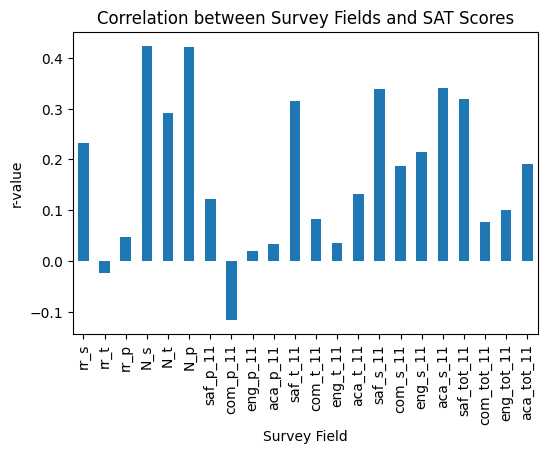

In [192]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()
plt.ylabel("r-value")
plt.xlabel("Survey Field")
plt.title("Correlation between Survey Fields and SAT Scores")
plt.show()

- We notice that the number of student respondents (<font color = blue>N_s</font>),number of teacher respondents (<font color = blue>N_t</font>) and the number of parents respondents (<font color = blue>N_p</font>) corrolate highly with <font color = red>sat_score</font>. This make sense because these columns   are correlated with <font color = red>total_enrollment</font>.


- Interestingly,  the student response rate, or the percentage of students that completed the survey (<font color=blue>rr_s</font>), correlates with <font color=red>sat_score</font>. This make sense, because students  who are more likely to fill out the surveys may be more likely to be doing well academically.


- Furthermore, how students and teachers percieved safety (<font color=blue>saf_t_11</font> and <font color=blue>saf_s_11</font>) correlate with <font color='red'>sat_score</font>. This also make sense, because teaching and learning is only possible in a safe environment. 


- The last interesting correlation is: there is a week positive correlation between how the student perceives academic standards  (<font color=blue>aca_s_11</font>) and <font color=red>sat_score</font>, but this is not true for how teachers perceive academic standards(<font color=blue>aca_t_11</font>), or how parents perceive academic standards(<font color=blue>aca_p_11,</font>).

# 2. Exploring Safety and SAT Scores

Previousily, we have noticed that <font color=blue>saf_t_11</font> and <font color=blue>saf_s_11</font>, which measure how teachers and students perceive safety at school, correlated highly with <font color=red>sat_score</font>. Next, we'll dig into this relationship a bit more and try to figure out which schools have low safety scores.

### Safety Scores

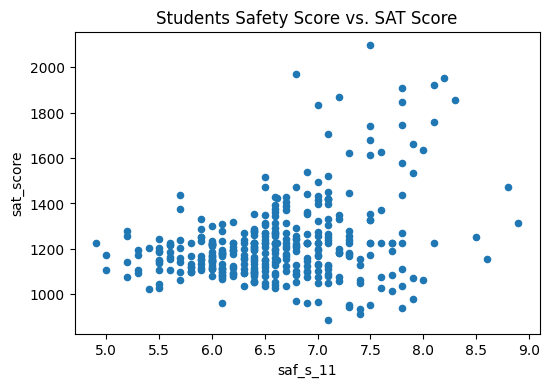

In [193]:
combined.plot.scatter("saf_s_11", "sat_score")
plt.title("Students Safety Score vs. SAT Score")
plt.show()

There seems to be a corrolation between Safety and Respect score based on student responses (<font color=blue>saf_s_11</font>) and <font color=blue>sat_score</font>, although it is not really strong.There seems to be a few schools with extremely high SAT scores and high safety scores. There are also a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

### Borough Safety Score 

Below we will compute the average safety score for each borough.

In [194]:
boroughs = combined.groupby("boro").agg(numpy.mean)["saf_s_11"].sort_values(ascending = False)
print(boroughs)

boro
Manhattan        6.831370
Queens           6.721875
Bronx            6.606577
Staten Island    6.530000
Brooklyn         6.370755
Name: saf_s_11, dtype: float64


We observe that Manhattan have the highest safety score, followed by Queens. Brooklyn have the lowest safety score. 

## 3. Exploring Race and SAT Scores

There are a few columns that indicate the percentage of each race at a given school:

- <font color=red>white_per</font>
- <font color=red>asian_per</font>
- <font color=red>black_per</font>
- <font color=red>hispanic_per</font>

By plotting out the correlations between these columns and <font color=red>sat_score</font>, we can determine whether there are any racial differences in SAT performance.

### Racial differences in SAT scores

Below we wil investigate racial differences in SAT scores.


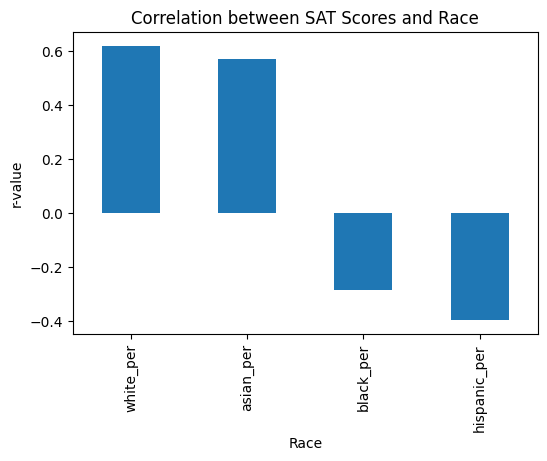

In [195]:
race = ["white_per", "asian_per", "black_per", "hispanic_per" ]
combined.corr()["sat_score"][race].plot.bar()
plt.xlabel("Race")
plt.ylabel("r-value")
plt.title("Correlation between SAT Scores and Race")
plt.show()

We observe that a higher percentage of white or asian students at a school correlates positively with sat scores, whereas a higher percentage of black or hispanic students correlates negatively with sat score as expected. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students. Furthermore, schools in such areas are highly likely to be unsafe due to the fact that most of them are located in Gang dominated beighnourhoods.

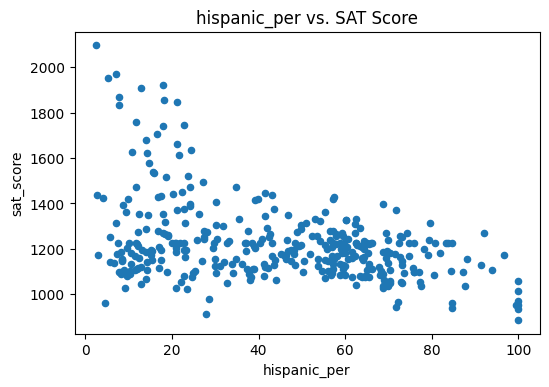

In [196]:
combined.plot.scatter("hispanic_per", "sat_score")
plt.title("hispanic_per vs. SAT Score")
plt.show()

Schools with the lowest percentage of hispanic student have the highest sat scores, while schools with the highest percentage of hispanic students have the lowest sat scores. This clearly indicate what we have already observed from the bar graph above.

Below, we will find the school names with the highest percentage of hispanic students (<font color=red>hispenic_per </font>><font color=red> 95%</font>)

In [197]:
combined[combined['hispanic_per']>95]["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed above appear to primarily enrolled students who recently immigrated to the US. Such schools have a lot of students who are learning English, which explain the lowest SAT scores.

Below, we will find the schools with <font color=red>hispenic_per </font>less than<font color=red> 10%</font>  and an average SAT score greater than <font color=red>1800</font>.

In [198]:
combined[(combined['hispanic_per']<10)&(combined['sat_score']>1800)]["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Most of the schools above are specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. Although, this does not explain the low <font color=red>hispanic_per</font>, it explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

## 4. Exploring Gender and SAT Scores

There are two columns that indicate the percentage of each gender at a school:

  - <font color=red>male_per</font>
  - <font color=red>female_per</font>
  
### a) Gender differences in SAT scores
We can plot out the correlations between the percentage of each gender and <font color=red>sat_score</font>.

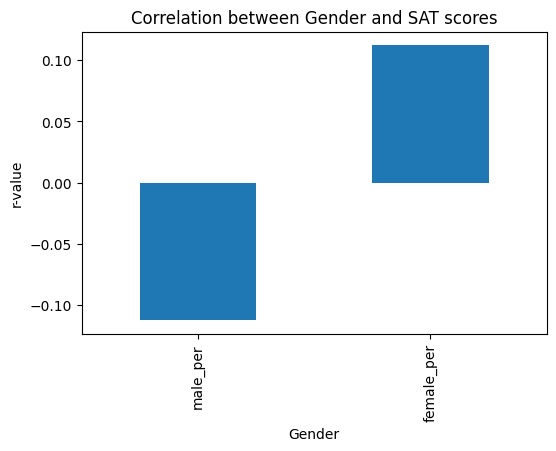

In [199]:
Gender =  ["male_per", "female_per"]
combined.corr()["sat_score"][Gender].plot.bar()
plt.title("Correlation between Gender and SAT scores")
plt.ylabel('r-value')
plt.xlabel('Gender')
plt.show()

We observe that the high percentage of males at a school is negatively correlated to SAT score, while the high percentage of females at a school is positively correlated to the SAT scores, and none of the correlation strong.

### b) Schools with high SAT scores and high female_per

Below we will investigate schools with high SAT scores and high <font color='red'>female_per</font> by making a scatter plot of <font color='red'>female_per</font>  vs. <font color='red'>sat_score</font> 

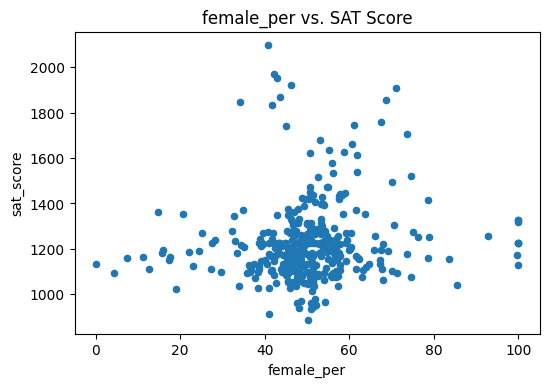

In [200]:
combined.plot.scatter("female_per", "sat_score")
plt.title("female_per vs. SAT Score")
plt.show()

From the scatterplot, we observe that it does not seem to be any real correlation between <font color=red>sat_score</font> and <font color=red>female_per</font>. However, there is a cluster of schools with a high percentage of females (60% to 80%), and high SAT scores.

Below we will find any the school with a <font color = red> female_per</font> greater than <font color = red> 60%</font> and an average SAT score greater than <font color='red'>1700</font>. 

In [201]:
combined[(combined['female_per']>60) & (combined['sat_score']>1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools above appears to be very selective liberal arts schools with have high academic standards.

## 5. Exploring AP Scores vs. SAT Scores

In the U.S., high school students take [Advanced Placement](https://en.wikipedia.org/wiki/Advanced_Placement_exams) (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because <font color=red>total_enrollment</font> is highly correlated with <font color=red>sat_score</font>, we don't want to lead to bias results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

In [202]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined['ap_per'].head()

0    0.305756
1    0.098985
2    0.031773
3    0.351577
4    0.158091
Name: ap_per, dtype: float64

below is a scatter plot of <font color =red>ap_per</font> vs. <font color=red>sat_score</font>.

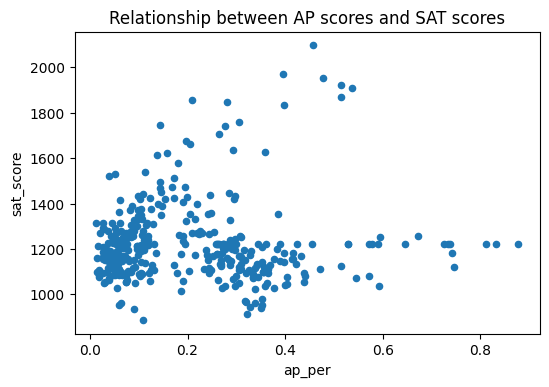

In [203]:
combined.plot.scatter('ap_per','sat_score')
plt.title("Relationship between AP scores and SAT scores")
plt.show()

There seem to be a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. But, the correlation between the percentage of students in a school who take the AP exam, and their average SAT scores is not really strong.